In [1]:
# Tratamiento de datos

import pandas as pd  # Manipulación y análisis de datos.
import numpy as np  # Soporte para vectores y matrices.

# Gráficos

import matplotlib.pyplot as plt  # Creación de gráficos estáticos, animados e interactivos.
from matplotlib import style  # Personalización del estilo de los gráficos.

# Preprocesado y modelado

from scipy.stats import pearsonr  # Coeficiente de correlación de Pearson.
from sklearn.model_selection import train_test_split  # División de datos en conjuntos de entrenamiento y prueba.
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Métricas para evaluar modelos.
import statsmodels.api as sm  # Modelos estadísticos y econometricos.
import statsmodels.formula.api as smf  # Modelo estadísticos con fórmulas.
from statsmodels.stats.anova import anova_lm  # Análisis de varianza.
from scipy import stats  # Funciones estadísticas.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler  # Preprocesamiento de datos.
import category_encoders  # Codificación de variables categóricas.
import missingno as msno  # Visualización de datos faltantes.
from sklearn.pipeline import Pipeline  # Cadena de transformaciones con un estimador final.
from sklearn.experimental import enable_iterative_imputer  # Permitir uso de IterativeImputer.
from sklearn.impute import IterativeImputer  # Imputación de datos faltantes.
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Modelos de ensamble.
from sklearn.model_selection import GridSearchCV, cross_val_score  # Búsqueda de hiperparámetros y validación cruzada.

# Deep Learning

import tensorflow as tf  # Biblioteca de Deep Learning.
from tensorflow.keras import layers, models  # Construcción de modelos de deep learning.
from keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Callbacks para controlar el entrenamiento.
from keras.models import Sequential  # Creación de modelos secuenciales.
from keras.layers import Dense, Dropout, BatchNormalization  # Capas para construir modelos.
from keras import regularizers  # Regularización de modelos.

In [ ]:
"""
En este notebook vamos a explorar otro modelo de Gradient Boosting para entrenar el modelo principal y uno de Random Forest
para entrenar el imputador MICE. Vistos los buenos resultados de los anteriores modelos vamos a modificar la columna PREVISION
con los datos salientes de la comparación de la PREVISION y la predicción respecto la producción real. El dato que esté mas cerca
de la predicción real pasará a la columna PREVISION: si el dato es mejor el de la previsión, se quedará, si es mejor el de la
predicción se substituirá el de la previsión por el de la predicción, así lograremos reentrenar el modelo con datos de previsión
más cercanos a la predicción.
"""

In [2]:
# Ruta del archivo, leemos el csv y lo guardamos en la variable df_central

df_central = pd.read_csv("https://raw.githubusercontent.com/jesusvillaalvarez/TFM_KSCHOL/main/5.ARCHIVOS/df_central_2_1.csv")


df_central.tail(10)

,Unnamed: 0,Fecha,Period,PREVISION,E_SIMEL,DESVIO,f_PREV_HIGH,f_PREV_LOW,f_RUN,Dia_Semana,Es_fin_semana,Año,Mes,Día
25056,25056,2023-11-15,15,22.9,5.740,17.160,1,0,1,2,False,2023,11,15
25057,25057,2023-11-15,16,28.8,3.356,25.444,1,0,1,2,False,2023,11,15
25058,25058,2023-11-15,17,30.6,2.224,28.376,1,0,1,2,False,2023,11,15
25059,25059,2023-11-15,18,15.7,4.066,11.634,1,0,1,2,False,2023,11,15
25060,25060,2023-11-15,19,0.4,0.008,0.392,1,0,1,2,False,2023,11,15
25061,25061,2023-11-15,20,0.0,0.000,0.000,0,0,0,2,False,2023,11,15
25062,25062,2023-11-15,21,0.0,0.000,0.000,0,0,0,2,False,2023,11,15
25063,25063,2023-11-15,22,0.0,0.000,0.000,0,0,0,2,False,2023,11,15
25064,25064,2023-11-15,23,0.0,0.000,0.000,0,0,0,2,False,2023,11,15
25065,25065,2023-11-15,24,0.0,0.000,0.000,0,0,0,2,False,2023,11,15


In [3]:
# df_central.info()

In [4]:
# Eliminamos las columnas que no utilizaremos para el modelado

df_central.drop(['Unnamed: 0', 'f_PREV_HIGH', 'f_PREV_LOW', 'DESVIO'], axis=1, inplace=True)

# Convertimos la columna 'Fecha' a Datetime

df_central['Fecha'] = pd.to_datetime(df_central['Fecha'])

# Convertimos la columna f_RUN a Boolano 

df_central['f_RUN'] = df_central['f_RUN'].astype(bool)

# df_central.head()


In [5]:
# Dividimos el DataFrame en dos: el primero para hacer el entrenamiento y prueba del modelo de predicción
# y el segundo para hacer las imputaciones, reentrenos de modelos y hacer las pruebas de predicción como si fuera un ejemplo real de datos nuevos.

df_inicio = df_central[df_central['Fecha'] <= '2023-10-31']
df_final = df_central[df_central['Fecha'] >= '2023-11-05']

In [6]:
# Con que ya tenemos columnas específicas que marcan los días, meses y años, eliminamos de los dos DataFrames
# la columna 'Fecha' para poder utilizar modelos de Random Forest y Gradient Boosting

df_inicio = df_inicio.drop('Fecha', axis=1)

df_final = df_final.drop('Fecha', axis=1)

In [7]:
df_inicio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24706 entries, 0 to 24705
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Period         24706 non-null  int64  
 1   PREVISION      24706 non-null  float64
 2   E_SIMEL        24706 non-null  float64
 3   f_RUN          24706 non-null  bool   
 4   Dia_Semana     24706 non-null  int64  
 5   Es_fin_semana  24706 non-null  bool   
 6   Año            24706 non-null  int64  
 7   Mes            24706 non-null  int64  
 8   Día            24706 non-null  int64  
dtypes: bool(2), float64(2), int64(5)
memory usage: 1.6 MB


In [8]:
# Excluimos la variable objetivo E_SIMEL

X_inicio = df_inicio.drop('E_SIMEL', axis=1)  
y_inicio = df_inicio['E_SIMEL']  # Definimos la variable objetivo

# Dividimos el conjunto de datos en entrenamiento (80%) y prueba (20%)

X_train_inicio, X_test_inicio, y_train_inicio, y_test_inicio = train_test_split(X_inicio, y_inicio, test_size=0.2, random_state=42)


In [9]:
# Antes de entrenar el modelo, haremos una búsqueda de mejores Hiperparámetros para un modelo de GradientBoostinRegressor

# Definimos el modelo de Gradient Boosting

gb_reg = GradientBoostingRegressor(random_state=42)

# Definimos los  parámetros para la búsqueda

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 6]
}

# Para la búsqueda de hiperparámetros utilizaremos el GridSearchCV

grid_search = GridSearchCV(estimator=gb_reg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# La búsqueda de los hiperparámetros la hacemos en el conjunto definido de entrenamiento

grid_search.fit(X_train_inicio, y_train_inicio)

# Visualizamos los resultados de los mejores hiperparámetros

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 300}
Mejor puntuación: -30.701483982842024


In [10]:
# Entrenamos el modelo con los resultados de los mejores Hiperparámetros

gb_reg_optimizado = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.1, max_depth=5, min_samples_split=4, random_state=42)

gb_reg_optimizado.fit(X_train_inicio, y_train_inicio)

# Después del entrenamiento, hacemos las predicciones en el conjunto de prueba definidio

y_pred_test = gb_reg_optimizado.predict(X_test_inicio)

# Calculamos las métricas para el conjunto de prueba

mse_test = mean_squared_error(y_test_inicio, y_pred_test)
r2_test = r2_score(y_test_inicio, y_pred_test)

# Calculamos la desviación estándar sobre la variable objetivo

std_train = y_train_inicio.std()
std_test = y_test_inicio.std()

print("MSE en el conjunto de prueba:", mse_test)
print("R² en el conjunto de prueba:", r2_test)
print("Desviación estándar en el conjunto de entrenamiento:", std_train)
print("Desviación estándar en el conjunto de prueba:", std_test)


MSE en el conjunto de prueba: 27.73973879747041
R² en el conjunto de prueba: 0.9027736687234934
Desviación estándar en el conjunto de entrenamiento: 16.661191176551633
Desviación estándar en el conjunto de prueba: 16.892859812860035


In [11]:
# Asignamos ciertos hiperparámetros para el modelo de RandomForestRegressor para la imputación

estimador_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

# Creamos el imputador MICE
mice_imputer = IterativeImputer(estimator=estimador_rf, random_state=42)

# Entrenamos el imputador con todas las variables menos con E_SIMEL

mice_imputer.fit(df_inicio[['Period', 'PREVISION','f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])



IterativeImputer(estimator=RandomForestRegressor(max_depth=10,
                                                 max_features='sqrt',
                                                 min_samples_leaf=2,
                                                 min_samples_split=4,
                                                 random_state=42),
                 random_state=42)

In [12]:
# Ahora empezamos con el proceso de predicciones para el conjunto de datos que separamos al principio: df_final


# seleccionamos las filas del 05-11-2023

df_final_05_11 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 5)]

# Para imputar valores a la columna f_RUN, creamos una variable con los datos del día 5
# donde quitamos la variable objetivo E_SIMEL y convertimos la variable para imputar f_RUN a valores nulos (NaN).

df_final_05_11_para_imputar = df_final_05_11.drop(['E_SIMEL'], axis=1)

df_final_05_11_para_imputar[['f_RUN']] = np.nan  

# Tal como comentamos anteriormente, en el momento de entrenar el modelo para el imputador, utilizamos todas las variables dando el imputador
# valores para todas ellas. Nosotros solo cogemos los valores para la columna f_RUN y imputamos los valores en el Dataframe de la predicción

valores_imputados = mice_imputer.transform(df_final_05_11_para_imputar[['Period', 'PREVISION', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])

# Seleccionar solo la primera columna del array 'valores_imputados', que corresponde a 'f_RUN'

valores_imputados_f_RUN = valores_imputados[:, 2]  

# Después de diferentes pruebas con distintos umbrales, elejimos el umbral en 0.2 para convertir a Booleano los resultados del imputador

valores_imputados_f_RUN_boolean = np.where(valores_imputados_f_RUN > 0.2, True, False)

# y actualizamos la columna f_RUN con los valores imputados

df_final_05_11.loc[df_final_05_11.index, 'f_RUN'] = valores_imputados_f_RUN_boolean


# Preparamos el conjunto de datos del día 5, excluyendo la variable objetivo E_SIMEL y procedemos a hacer la predicción con el modelo
# de Gradient Boosting entrenado

caracteristicas_para_prediccion = df_final_05_11.drop('E_SIMEL', axis=1)  


predicted_e_simel_05_11 = gb_reg_optimizado.predict(caracteristicas_para_prediccion)

# El modelo de Gradient Boosting puede devolvernos resultados negativos. Los valores negativos no tienen sentido para la predicción por lo que obtamos por transformar
# los valores negativos en cero 

predicted_e_simel_05_11 = np.maximum(predicted_e_simel_05_11, 0)

# Creamos un Dataframe para almacenar los resultados de la predicción junto a otras variables relevantes para poder visualizarlos.

df_predicciones_05_11 = df_final_05_11[['Año', 'Mes', 'Día', 'PREVISION', 'E_SIMEL']].copy()
df_predicciones_05_11['predicted_E_SIMEL'] = predicted_e_simel_05_11

# Mostramos en caso necesario el DataFrame resultante

# df_predicciones_05_11.head(30)


In [13]:
# A partir del df_predicciones calcularemos las sumas y desviaciones porcentuales de las columnas de Previsión, Predicción y producción real
# Este proceso lo vamos a repetir a lo largo de todas las predicciones de df_final

suma_real_05 = df_predicciones_05_11['E_SIMEL'].sum()
suma_predicha_05 = df_predicciones_05_11['predicted_E_SIMEL'].sum()
suma_prevision_05 = df_predicciones_05_11['PREVISION'].sum()

# Ya que vamos a modificar la columna PREVISIÓN cada vez que hagamos una predicción, para tener una visión real de los resultados debemos hacer la comparación
# respecto de las previsiones reales y no de las previsiones actualizadas que utilizaremos a lo largo de las predicciones.
# Sacamos la columna PREVISION de df_final para el día concreto, guardamos el df y hacemos la suma de valores

df_final_PREV_05 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 5)]
df_final_PREV_05_11 = df_final_PREV_05[['PREVISION']].copy()
suma_prevision_05_real = df_final_PREV_05['PREVISION'].sum()


# Calculamos la desviación de la predicción

if suma_real_05 != 0:
    desviacion_porcentual = 100 * (suma_predicha_05 - suma_real_05) / suma_real_05
else:
    desviacion_porcentual = float('inf')  # En caso de división por cero nos devolverá una valor especial para que nos dé error el código


# Calculamos la desviación porcentual de la'PREVISION' actualizada
    
if suma_real_05 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_05 - suma_real_05) / suma_real_05
else:
    desviacion_porcentual_prevision = float('inf')  
    

# Calculamos la desviación porcentual de la 'PREVISION' real del df_final para el día concreto
    
if suma_real_05 != 0:
    desviacion_porcentual_prevision_real = 100 * (suma_prevision_05_real - suma_real_05) / suma_real_05
else:
    desviacion_porcentual_prevision_real = float('inf')  


# Imprimimos los resultados de las sumas y de las desviaciones porcentuales  
    
print("Suma real: ", suma_real_05)
print("Suma predicha: ", suma_predicha_05)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_05)
print('Suma Previsión real: ', suma_prevision_05_real)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")
print("Desviación porcentual: ", desviacion_porcentual_prevision_real, "%")

Suma real:  15.937000000000001
Suma predicha:  35.069036859281866
Desviación porcentual:  120.04791905177801 %
Suma previsión:  0.0
Suma Previsión real:  0.0
Desviación porcentual:  -100.0 %
Desviación porcentual:  -100.0 %


In [14]:
""" 
Ahora vamos a hacer el proceso de cuando pasamos los datos del día que hemos hecho la predicción 
al df_inicio para reentrenar modelos, vamos a sustituir en la columna PREVISION, 
los mejores valores entre PREVISION  y predicción respecto la producción real, es decir, 
intentaremos que la columna PREVISION que pasamos a los datos de df_inicio contenga los datos
más próximos a la producción real, para ver si con esta modificación podemos mejorar las predicciones.

"""

' \nAhora vamos a hacer el proceso de cuando pasamos los datos del día que hemos hecho la predicción \nal df_inicio para reentrenar modelos, vamos a sustituir en la columna PREVISION, \nlos mejores valores entre PREVISION  y predicción respecto la producción real, es decir, \nintentaremos que la columna PREVISION que pasamos a los datos de df_inicio contenga los datos\nmás próximos a la producción real, para ver si con esta modificación podemos mejorar las predicciones.\n\n'

In [15]:
# Calculamos la diferencia absoluta entre la producción real y las previsiones/predicciones

df_predicciones_05_11['dif_abs_prevision'] = abs(df_predicciones_05_11['E_SIMEL'] - df_predicciones_05_11['PREVISION'])
df_predicciones_05_11['dif_abs_prediccion'] = abs(df_predicciones_05_11['E_SIMEL'] - df_predicciones_05_11['predicted_E_SIMEL'])

# Creamos una nueva columna con el mejor_dato y lo especificamos si viene de la predicción o de la prevision

df_predicciones_05_11['mejor_dato'] = np.where(df_predicciones_05_11['dif_abs_prediccion'] < df_predicciones_05_11['dif_abs_prevision'], 'Predicción', 'Previsión')

# Mostramos el Dataframe resultante donde podemos ver las nuevas columnas creadas

df_predicciones_05_11[['Año', 'Mes', 'Día', 'PREVISION', 'E_SIMEL', 'predicted_E_SIMEL', 'dif_abs_prevision', 'dif_abs_prediccion', 'mejor_dato']]


,Año,Mes,Día,PREVISION,E_SIMEL,predicted_E_SIMEL,dif_abs_prevision,dif_abs_prediccion,mejor_dato
24802,2023,11,5,0.0,0.000,0.000000,0.000,0.000000,Previsión
24803,2023,11,5,0.0,0.000,0.000000,0.000,0.000000,Previsión
24804,2023,11,5,0.0,0.000,0.000000,0.000,0.000000,Previsión
24805,2023,11,5,0.0,0.000,0.000000,0.000,0.000000,Previsión
24806,2023,11,5,0.0,0.000,0.000000,0.000,0.000000,Previsión
24807,2023,11,5,0.0,0.000,0.000000,0.000,0.000000,Previsión
24808,2023,11,5,0.0,0.000,0.000000,0.000,0.000000,Previsión
24809,2023,11,5,0.0,0.000,0.000000,0.000,0.000000,Previsión
24810,2023,11,5,0.0,0.000,0.000000,0.000,0.000000,Previsión
24811,2023,11,5,0.0,0.000,0.000000,0.000,0.000000,Previsión


In [16]:
# Primero, nos aseguramos de que df_predicciones_06_11 y df_final están alineados y tienen la misma longitud para el día en cuestión


# Creamos una nueva columna 'PREVISION_ACTUALIZADA' en df_final

df_final_05_11['PREVISION_ACTUALIZADA'] = df_final_05_11.apply(
    lambda row: df_predicciones_05_11.loc[row.name, 'predicted_E_SIMEL']
    if (row.name in df_predicciones_05_11.index and 
        df_predicciones_05_11.loc[row.name, 'mejor_dato'] == 'Predicción')
    else row['PREVISION'],
    axis=1
)

# Remplazamos la columna 'PREVISION' en df_final con 'PREVISION_ACTUALIZADA'

df_final_05_11['PREVISION'] = df_final_05_11['PREVISION_ACTUALIZADA']

# Eliminamos la columna 'PREVISION_ACTUALIZADA' ya que no es necesaria

df_final_05_11.drop('PREVISION_ACTUALIZADA', axis=1, inplace=True)

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_102352\1592048485.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_05_11['PREVISION_ACTUALIZADA'] = df_final_05_11.apply(
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_102352\1592048485.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_05_11['PREVISION'] = df_final_05_11['PREVISION_ACTUALIZADA']
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_102352\1592048485.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [17]:
# Actualizamos df_inicio con los datos del día 5 con la columna PREVISION actualizada

df_inicio_actualizado = pd.concat([df_inicio, df_final_05_11])




In [18]:
df_inicio_actualizado.tail(24)

,Period,PREVISION,E_SIMEL,f_RUN,Dia_Semana,Es_fin_semana,Año,Mes,Día
24802,1,0.000000,0.000,False,6,True,2023,11,5
24803,2,0.000000,0.000,False,6,True,2023,11,5
24804,3,0.000000,0.000,False,6,True,2023,11,5
24805,4,0.000000,0.000,False,6,True,2023,11,5
24806,5,0.000000,0.000,False,6,True,2023,11,5
24807,6,0.000000,0.000,False,6,True,2023,11,5
24808,7,0.000000,0.000,False,6,True,2023,11,5
24809,8,0.000000,0.000,False,6,True,2023,11,5
24810,9,0.000000,0.000,False,6,True,2023,11,5
24811,10,0.000000,0.000,False,6,True,2023,11,5


In [19]:
# Comprobaremos ahora como la columna PREVISIÓN ha canviado respecto a la original ya que
# ahora contiene los datos que más se acercan a la producción real

df_final_05_11_prueba = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 5)]

df_final_05_11_prueba

,Period,PREVISION,E_SIMEL,f_RUN,Dia_Semana,Es_fin_semana,Año,Mes,Día
24802,1,0.0,0.000,False,6,True,2023,11,5
24803,2,0.0,0.000,False,6,True,2023,11,5
24804,3,0.0,0.000,False,6,True,2023,11,5
24805,4,0.0,0.000,False,6,True,2023,11,5
24806,5,0.0,0.000,False,6,True,2023,11,5
24807,6,0.0,0.000,False,6,True,2023,11,5
24808,7,0.0,0.000,False,6,True,2023,11,5
24809,8,0.0,0.000,False,6,True,2023,11,5
24810,9,0.0,0.000,False,6,True,2023,11,5
24811,10,0.0,0.000,False,6,True,2023,11,5


In [20]:
# Reentrenamos el modelo con df_inicio actualizado

X_train_actualizado = df_inicio_actualizado.drop('E_SIMEL', axis=1)
y_train_actualizado = df_inicio_actualizado['E_SIMEL']
gb_reg_optimizado.fit(X_train_actualizado, y_train_actualizado)



GradientBoostingRegressor(max_depth=5, min_samples_split=4, n_estimators=300,
                          random_state=42)

In [21]:


# Reentrenamos el imputador con df_inicio_actualizado con todas las variables menos con E_SIMEL

mice_imputer.fit(df_inicio_actualizado[['Period', 'PREVISION', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])

IterativeImputer(estimator=RandomForestRegressor(max_depth=10,
                                                 max_features='sqrt',
                                                 min_samples_leaf=2,
                                                 min_samples_split=4,
                                                 random_state=42),
                 random_state=42)

In [22]:
# Y seguimos con el mismo proceso que hemos hecho para el día 5. Preparar los datos para la imputación de f_RUN
# y hacer la predicción

df_final_06_11 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 6)]

df_final_06_11_para_imputar = df_final_06_11.drop(['E_SIMEL'], axis=1)

df_final_06_11_para_imputar[['f_RUN']] = np.nan  

valores_imputados_06 = mice_imputer.transform(df_final_06_11_para_imputar[['Period', 'PREVISION', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])

valores_imputados_f_RUN_06 = valores_imputados[:, 2]  

valores_imputados_f_RUN_boolean_06 = np.where(valores_imputados_f_RUN_06 > 0.2, True, False)

df_final_06_11.loc[df_final_06_11.index, 'f_RUN'] = valores_imputados_f_RUN_boolean_06



caracteristicas_para_prediccion = df_final_06_11.drop('E_SIMEL', axis=1) 

predicted_e_simel_06_11 = gb_reg_optimizado.predict(caracteristicas_para_prediccion)

predicted_e_simel_06_11 = np.maximum(predicted_e_simel_06_11, 0)



df_predicciones_06_11 = df_final_06_11[['Año', 'Mes', 'Día', 'PREVISION', 'E_SIMEL']].copy()
df_predicciones_06_11['predicted_E_SIMEL'] = predicted_e_simel_06_11

# Mostramos el DataFrame resultante
# df_predicciones_06_11.head(30)

In [23]:
# Sumas y porcentajes

suma_real_06 = df_predicciones_06_11['E_SIMEL'].sum()
suma_predicha_06 = df_predicciones_06_11['predicted_E_SIMEL'].sum()
suma_prevision_06 = df_predicciones_06_11['PREVISION'].sum()

df_final_PREV_06 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 6)]
df_final_PREV_06_11 = df_final_PREV_06[['PREVISION']].copy()
suma_prevision_06_real = df_final_PREV_06['PREVISION'].sum()


if suma_real_06 != 0:
    desviacion_porcentual = 100 * (suma_predicha_06 - suma_real_06) / suma_real_06
else:
    desviacion_porcentual = float('inf')  


if suma_real_06 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_06 - suma_real_06) / suma_real_06
else:
    desviacion_porcentual_prevision = float('inf')  

    
if suma_real_06 != 0:
    desviacion_porcentual_prevision_real = 100 * (suma_prevision_06_real - suma_real_06) / suma_real_06
else:
    desviacion_porcentual_prevision_real = float('inf')   
     

print("Suma real: ", suma_real_06)
print("Suma predicha: ", suma_predicha_06)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_06)
print('Suma Previsión real: ', suma_prevision_06_real)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")
print("Desviación porcentual: ", desviacion_porcentual_prevision_real, "%")

Suma real:  58.542
Suma predicha:  90.2731266806694
Desviación porcentual:  54.20232769749821 %
Suma previsión:  159.4
Suma Previsión real:  159.4
Desviación porcentual:  172.2831471422227 %
Desviación porcentual:  172.2831471422227 %


In [24]:
# Calculamos la diferencia absoluta entre la producción real y las previsiones/predicciones

df_predicciones_06_11['dif_abs_prevision'] = abs(df_predicciones_06_11['E_SIMEL'] - df_predicciones_06_11['PREVISION'])
df_predicciones_06_11['dif_abs_prediccion'] = abs(df_predicciones_06_11['E_SIMEL'] - df_predicciones_06_11['predicted_E_SIMEL'])

# Decidimos qué dato es mejor (previsión o predicción) para cada hora

df_predicciones_06_11['mejor_dato'] = np.where(df_predicciones_06_11['dif_abs_prediccion'] < df_predicciones_06_11['dif_abs_prevision'], 'Predicción', 'Previsión')

# Mostramos el DataFrame resultante

df_predicciones_06_11[['Año', 'Mes', 'Día', 'PREVISION', 'E_SIMEL', 'predicted_E_SIMEL', 'dif_abs_prevision', 'dif_abs_prediccion', 'mejor_dato']]

,Año,Mes,Día,PREVISION,E_SIMEL,predicted_E_SIMEL,dif_abs_prevision,dif_abs_prediccion,mejor_dato
24826,2023,11,6,0.0,0.000,0.000000,0.000,0.000000,Previsión
24827,2023,11,6,0.0,0.000,0.000000,0.000,0.000000,Previsión
24828,2023,11,6,0.0,0.000,0.000000,0.000,0.000000,Previsión
24829,2023,11,6,0.0,0.000,0.000000,0.000,0.000000,Previsión
24830,2023,11,6,0.0,0.000,0.000000,0.000,0.000000,Previsión
24831,2023,11,6,0.0,0.000,0.000000,0.000,0.000000,Previsión
24832,2023,11,6,0.0,0.000,0.000000,0.000,0.000000,Previsión
24833,2023,11,6,0.0,0.000,0.000000,0.000,0.000000,Previsión
24834,2023,11,6,0.0,0.000,0.000000,0.000,0.000000,Previsión
24835,2023,11,6,0.0,0.000,0.000000,0.000,0.000000,Previsión


In [25]:
# Creamos una nueva columna 'PREVISION_ACTUALIZADA' en df_final_06_11

df_final_06_11['PREVISION_ACTUALIZADA'] = df_final_06_11.apply(
    lambda row: df_predicciones_06_11.loc[row.name, 'predicted_E_SIMEL']
    if (row.name in df_predicciones_06_11.index and 
        df_predicciones_06_11.loc[row.name, 'mejor_dato'] == 'Predicción')
    else row['PREVISION'],
    axis=1
)

# Remplazamos la columna 'PREVISION' en df_final_06_11 con 'PREVISION_ACTUALIZADA'

df_final_06_11['PREVISION'] = df_final_06_11['PREVISION_ACTUALIZADA']

# Eliminamos la columna 'PREVISION_ACTUALIZADA' ya que no es necesaria

df_final_06_11.drop('PREVISION_ACTUALIZADA', axis=1, inplace=True)

# creamos una nueva variable para poder utilizarla en la función

df_final_actualizado = df_final_06_11


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_102352\3585816624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_06_11['PREVISION_ACTUALIZADA'] = df_final_06_11.apply(
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_102352\3585816624.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_06_11['PREVISION'] = df_final_06_11['PREVISION_ACTUALIZADA']
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_102352\3585816624.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [26]:
   
def predecir_y_actualizar_para_un_dia(dia_siguiente, mes, año, df_inicio_actualizado, df_dia_actual_actualizado, df_final, modelo_gb, imputador):
    """
    Esta función actualiza el conjunto de entrenamiento con los datos reales y 
    previsiones actualizadas de un día específico y realiza la predicción para el día siguiente.
    """
    
    # Concatenamos df_inicio_actualizado con los datos del dia_actual que incluyen la previsión actualizada

    df_inicio_actualizado = pd.concat([df_inicio_actualizado, df_dia_actual_actualizado])

    # Reentrenamos el modelo de predicción y el imputador MICE

    X_train_actualizado = df_inicio_actualizado.drop('E_SIMEL', axis=1)
    y_train_actualizado = df_inicio_actualizado['E_SIMEL']
    modelo_gb.fit(X_train_actualizado, y_train_actualizado)
    imputador.fit(X_train_actualizado[['Period', 'PREVISION', 'f_RUN', 'Dia_Semana', 'Es_fin_semana', 'Año', 'Mes', 'Día']])

    # Preparamos los datos del día siguiente para la imputación y predicción

    df_dia_siguiente = df_final[(df_final['Año'] == año) & (df_final['Mes'] == mes) & (df_final['Día'] == dia_siguiente)].copy()
    df_dia_siguiente_para_imputar = df_dia_siguiente.drop(['E_SIMEL'], axis=1).copy()
    df_dia_siguiente_para_imputar['f_RUN'] = np.nan
    valores_imputados = imputador.transform(df_dia_siguiente_para_imputar)
    df_dia_siguiente['f_RUN'] = np.where(valores_imputados[:, 2] > 0.2, True, False)

    # Realizamos la predicción para el día siguiente

    X_prediccion = df_dia_siguiente.drop('E_SIMEL', axis=1)
    predicted_e_simel = modelo_gb.predict(X_prediccion)
    predicted_e_simel = np.maximum(predicted_e_simel, 0)  # Nos aseguramos que no hay valores negativos en la predicción
    df_dia_siguiente['predicted_E_SIMEL'] = predicted_e_simel
    
   # Dataframe con los resultados de la predicción
    
    df_predicciones = df_dia_siguiente[['Año', 'Mes', 'Día', 'PREVISION', 'E_SIMEL']].copy()
    df_predicciones['predicted_E_SIMEL'] = predicted_e_simel

    # Calculamos las métricas para las predicciones

    mse = mean_squared_error(df_predicciones['E_SIMEL'], df_predicciones['predicted_E_SIMEL'])
    r2 = r2_score(df_predicciones['E_SIMEL'], df_predicciones['predicted_E_SIMEL'])
    mae = mean_absolute_error(df_predicciones['E_SIMEL'], df_predicciones['predicted_E_SIMEL'])

    # Calculamos las diferencias absolutas
    df_dia_siguiente['dif_abs_prevision'] = abs(df_dia_siguiente['E_SIMEL'] - df_dia_siguiente['PREVISION'])
    df_dia_siguiente['dif_abs_prediccion'] = abs(df_dia_siguiente['E_SIMEL'] - df_dia_siguiente['predicted_E_SIMEL'])

   

    # Mejor dato de (previsión o predicción) y actualizamos 'PREVISION' si es necesario

    df_dia_siguiente['mejor_dato'] = np.where(df_dia_siguiente['dif_abs_prediccion'] < df_dia_siguiente['dif_abs_prevision'], 'Predicción', 'Previsión')
    df_dia_siguiente.loc[df_dia_siguiente['mejor_dato'] == 'Predicción', 'PREVISION'] = df_dia_siguiente['predicted_E_SIMEL']

    # Dataframe con los resultados de la predicción

    df_predicciones = df_dia_siguiente[['Año', 'Mes', 'Día', 'PREVISION', 'E_SIMEL', 'predicted_E_SIMEL', 'dif_abs_prevision', 'dif_abs_prediccion', 'mejor_dato']].copy()
    
    # Actualizamos df_final con las previsiones mejoradas
    
    for idx, row in df_predicciones.iterrows():
        if row['mejor_dato'] == 'Predicción':
            df_dia_siguiente.loc[idx, 'PREVISION'] = row['predicted_E_SIMEL']

    df_dia_actual_actualizado = df_dia_siguiente.drop(['predicted_E_SIMEL', 'dif_abs_prevision', 'dif_abs_prediccion', 'mejor_dato'], axis = 1).copy()
    
    

    return df_predicciones, df_inicio_actualizado, mse, r2, mae, df_dia_actual_actualizado


In [27]:
dia_siguiente = 7
df_predicciones_07_11, df_inicio_actualizado, mse_07_11, r2_07_11, mae_07_11, df_dia_actual_actualizado = predecir_y_actualizar_para_un_dia(dia_siguiente, 11, 2023, df_inicio_actualizado, df_final_actualizado, df_final, gb_reg_optimizado, mice_imputer)
print("MSE:", mse_07_11, "R²:", r2_07_11, "MAE:", mae_07_11)

MSE: 31.491926531717812 R²: 0.20996306999685177 MAE: 2.943141653021472


In [28]:
df_dia_actual_actualizado

,Period,PREVISION,E_SIMEL,f_RUN,Dia_Semana,Es_fin_semana,Año,Mes,Día
24850,1,0.000000,0.000,False,1,False,2023,11,7
24851,2,0.000000,0.000,False,1,False,2023,11,7
24852,3,0.000000,0.000,False,1,False,2023,11,7
24853,4,0.000000,0.000,False,1,False,2023,11,7
24854,5,0.000000,0.000,False,1,False,2023,11,7
24855,6,0.000000,0.000,False,1,False,2023,11,7
24856,7,0.000000,0.000,False,1,False,2023,11,7
24857,8,0.000000,0.000,False,1,False,2023,11,7
24858,9,0.000000,0.000,False,1,False,2023,11,7
24859,10,0.000000,0.000,False,1,False,2023,11,7


In [29]:
# Sumatorios y porcentajes

suma_real_07 = df_predicciones_07_11['E_SIMEL'].sum()
suma_predicha_07 = df_predicciones_07_11['predicted_E_SIMEL'].sum()
suma_prevision_07 = df_predicciones_07_11['PREVISION'].sum()

df_final_PREV_07 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 7)]
df_final_PREV_07_11 = df_final_PREV_07[['PREVISION']].copy()
suma_prevision_07_real = df_final_PREV_07['PREVISION'].sum()


if suma_real_07 != 0:
    desviacion_porcentual = 100 * (suma_predicha_07 - suma_real_07) / suma_real_07
else:
    desviacion_porcentual = float('inf')  


if suma_real_07 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_07 - suma_real_07) / suma_real_07
else:
    desviacion_porcentual_prevision = float('inf')  

    
if suma_real_07 != 0:
    desviacion_porcentual_prevision_real = 100 * (suma_prevision_07_real - suma_real_07) / suma_real_07
else:
    desviacion_porcentual_prevision_real = float('inf')     
    

print("Suma real: ", suma_real_07)
print("Suma predicha: ", suma_predicha_07)
print("Desviación porcentual: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_07)
print('Suma Previsión real: ', suma_prevision_07_real)
print("Desviación porcentual: ", desviacion_porcentual_prevision, "%")
print("Desviación porcentual: ", desviacion_porcentual_prevision_real, "%")

Suma real:  67.97999999999999
Suma predicha:  45.87427982433819
Desviación porcentual:  -32.51797613365961 %
Suma previsión:  34.60944007591144
Suma Previsión real:  24.0
Desviación porcentual:  -49.08879070916234 %
Desviación porcentual:  -64.6954986760812 %


In [30]:
dia_siguiente = 8
df_predicciones_08_11, df_inicio_actualizado, mse_08_11, r2_08_11, mae_08_11, df_dia_actual_actualizado = predecir_y_actualizar_para_un_dia(dia_siguiente, 11, 2023, df_inicio_actualizado, df_dia_actual_actualizado, df_final, gb_reg_optimizado, mice_imputer)
print("MSE:", mse_08_11, "R²:", r2_08_11, "MAE:", mae_08_11)

MSE: 2.8993730669157887 R²: 0.045476466329017806 MAE: 0.9746636544411608


In [31]:
# Sumas y porcentajes

suma_real_08 = df_predicciones_08_11['E_SIMEL'].sum()
suma_predicha_08 = df_predicciones_08_11['predicted_E_SIMEL'].sum()
suma_prevision_08 = df_predicciones_08_11['PREVISION'].sum()

df_final_PREV_08 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 8)]
df_final_PREV_08_11 = df_final_PREV_08[['PREVISION']].copy()
suma_prevision_08_real = df_final_PREV_08['PREVISION'].sum()


if suma_real_08 != 0:
    desviacion_porcentual = 100 * (suma_predicha_08 - suma_real_08) / suma_real_08
else:
    desviacion_porcentual = float('inf')  


if suma_real_08 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_08 - suma_real_08) / suma_real_08
else:
    desviacion_porcentual_prevision = float('inf')  

    
if suma_real_08 != 0:
    desviacion_porcentual_prevision_real = 100 * (suma_prevision_08_real - suma_real_08) / suma_real_08
else:
    desviacion_porcentual_prevision_real = float('inf') 
    
       

print("Suma real: ", suma_real_08)
print("Suma predicha: ", suma_predicha_08)
print("Desviación porcentual predicción: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_08)
print('Suma Previsión real: ', suma_prevision_08_real)
print("Desviación porcentual previsión actualizada: ", desviacion_porcentual_prevision, "%")
print("Desviación porcentual real prevision: ", desviacion_porcentual_prevision_real, "%")

Suma real:  11.296999999999999
Suma predicha:  18.203642803230913
Desviación porcentual predicción:  61.13696382429774 %
Suma previsión:  3.0543575483215273
Suma Previsión real:  0.0
Desviación porcentual previsión actualizada:  -72.96310924739728 %
Desviación porcentual real prevision:  -100.0 %


In [32]:
dia_siguiente = 9
df_predicciones_09_11, df_inicio_actualizado, mse_09_11, r2_09_11, mae_09_11, df_dia_actual_actualizado = predecir_y_actualizar_para_un_dia(dia_siguiente, 11, 2023, df_inicio_actualizado, df_final_actualizado, df_final, gb_reg_optimizado, mice_imputer)
print("MSE:", mse_09_11, "R²:", r2_09_11, "MAE:", mae_09_11)

MSE: 23.578768760173674 R²: 0.74787660119386 MAE: 2.8984957243259615


In [33]:
# Sumas y porcentajes

suma_real_09 = df_predicciones_09_11['E_SIMEL'].sum()
suma_predicha_09 = df_predicciones_09_11['predicted_E_SIMEL'].sum()
suma_prevision_09 = df_predicciones_09_11['PREVISION'].sum()

df_final_PREV_09 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] == 9)]
df_final_PREV_09_11 = df_final_PREV_09[['PREVISION']].copy()
suma_prevision_09_real = df_final_PREV_09['PREVISION'].sum()


if suma_real_09 != 0:
    desviacion_porcentual = 100 * (suma_predicha_09 - suma_real_09) / suma_real_09
else:
    desviacion_porcentual = float('inf')  



if suma_real_09 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_09 - suma_real_09) / suma_real_09
else:
    desviacion_porcentual_prevision = float('inf')  


    
if suma_real_09 != 0:
    desviacion_porcentual_prevision_real = 100 * (suma_prevision_09_real - suma_real_09) / suma_real_09
else:
    desviacion_porcentual_prevision_real = float('inf')    
    

print("Suma real: ", suma_real_09)
print("Suma predicha: ", suma_predicha_09)
print("Desviación porcentual predicción: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_09)
print('Suma Previsión real: ', suma_prevision_09_real)
print("Desviación porcentual previsión actualizada: ", desviacion_porcentual_prevision, "%")
print("Desviación porcentual real prevision: ", desviacion_porcentual_prevision_real, "%")

Suma real:  102.43700000000001
Suma predicha:  115.30917754717558
Desviación porcentual predicción:  12.565945456403025 %
Suma previsión:  116.88692986010369
Suma Previsión real:  127.30000000000001
Desviación porcentual previsión actualizada:  14.106162675696943 %
Desviación porcentual real prevision:  24.271503460663627 %


In [34]:
dia_siguiente = 10
df_predicciones_10_11, df_inicio_actualizado, mse_10_11, r2_10_11, mae_10_11, df_dia_actual_actualizado = predecir_y_actualizar_para_un_dia(dia_siguiente, 11, 2023, df_inicio_actualizado, df_final_actualizado, df_final, gb_reg_optimizado, mice_imputer)
print("MSE:", mse_10_11, "R²:", r2_10_11, "MAE:", mae_10_11)

MSE: 29.36383672050854 R²: -0.21148238791373686 MAE: 3.2648112369119606


In [35]:
# Sumatorios y procentajes

suma_real_10 = df_predicciones_10_11['E_SIMEL'].sum()
suma_predicha_10 = df_predicciones_10_11['predicted_E_SIMEL'].sum()
suma_prevision_10 = df_predicciones_10_11['PREVISION'].sum()

df_final_PREV_10 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] ==10)]
df_final_PREV_10_11 = df_final_PREV_10[['PREVISION']].copy()
suma_prevision_10_real = df_final_PREV_10['PREVISION'].sum()


if suma_real_10 != 0:
    desviacion_porcentual = 100 * (suma_predicha_10 - suma_real_10) / suma_real_10
else:
    desviacion_porcentual = float('inf')  



if suma_real_10 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_10 - suma_real_10) / suma_real_10
else:
    desviacion_porcentual_prevision = float('inf')  


    
if suma_real_10 != 0:
    desviacion_porcentual_prevision_real = 100 * (suma_prevision_10_real - suma_real_10) / suma_real_10
else:
    desviacion_porcentual_prevision_real = float('inf')    

print("Suma real: ", suma_real_10)
print("Suma predicha: ", suma_predicha_10)
print("Desviación porcentual predicción: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_10)
print('Suma Previsión real: ', suma_prevision_10_real)
print("Desviación porcentual previsión actualizada: ", desviacion_porcentual_prevision, "%")
print("Desviación porcentual real prevision: ", desviacion_porcentual_prevision_real, "%")

Suma real:  58.955
Suma predicha:  134.79982713663767
Desviación porcentual predicción:  128.64867634066266 %
Suma previsión:  108.53767872537532
Suma Previsión real:  112.6
Desviación porcentual previsión actualizada:  84.10258455665392 %
Desviación porcentual real prevision:  90.99313035365958 %


In [36]:
dia_siguiente = 13
df_predicciones_13_11, df_inicio_actualizado, mse_13_11, r2_13_11, mae_13_11, df_dia_actual_actualizado = predecir_y_actualizar_para_un_dia(dia_siguiente, 11, 2023, df_inicio_actualizado, df_final_actualizado, df_final, gb_reg_optimizado, mice_imputer)
print("MSE:", mse_13_11, "R²:", r2_13_11, "MAE:", mae_13_11)

MSE: 66.87742658643023 R²: 0.23346354939368175 MAE: 3.763082292102252


In [37]:
# Sumatorios y porcentajes

suma_real_13 = df_predicciones_13_11['E_SIMEL'].sum()
suma_predicha_13 = df_predicciones_13_11['predicted_E_SIMEL'].sum()
suma_prevision_13 = df_predicciones_13_11['PREVISION'].sum()

df_final_PREV_13 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] ==13)]
df_final_PREV_13_11 = df_final_PREV_13[['PREVISION']].copy()
suma_prevision_13_real = df_final_PREV_13['PREVISION'].sum()


if suma_real_13 != 0:
    desviacion_porcentual = 100 * (suma_predicha_13 - suma_real_13) / suma_real_13
else:
    desviacion_porcentual = float('inf')  


    
if suma_real_13 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_13 - suma_real_13) / suma_real_13
else:
    desviacion_porcentual_prevision = float('inf')  


    
if suma_real_13 != 0:
    desviacion_porcentual_prevision_real = 100 * (suma_prevision_13_real - suma_real_13) / suma_real_13
else:
    desviacion_porcentual_prevision_real = float('inf')  


print("Suma real: ", suma_real_13)
print("Suma predicha: ", suma_predicha_13)
print("Desviación porcentual predicción: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_13)
print('Suma Previsión real: ', suma_prevision_13_real)
print("Desviación porcentual previsión actualizada: ", desviacion_porcentual_prevision, "%")
print("Desviación porcentual real prevision: ", desviacion_porcentual_prevision_real, "%")

Suma real:  107.141
Suma predicha:  39.16442044506548
Desviación porcentual predicción:  -63.44590731366565 %
Suma previsión:  28.192545315801105
Suma Previsión real:  20.900000000000002
Desviación porcentual previsión actualizada:  -73.68650160461345 %
Desviación porcentual real prevision:  -80.492995211917 %


In [38]:
dia_siguiente = 14
df_predicciones_14_11, df_inicio_actualizado, mse_14_11, r2_14_11, mae_14_11, df_dia_actual_actualizado = predecir_y_actualizar_para_un_dia(dia_siguiente, 11, 2023, df_inicio_actualizado, df_final_actualizado, df_final, gb_reg_optimizado, mice_imputer)
print("MSE:", mse_14_11, "R²:", r2_14_11, "MAE:", mae_14_11)

MSE: 19.90917576238112 R²: 0.7885325124475246 MAE: 2.605806738115741


In [39]:
# Sumatorios y porcentajes

suma_real_14 = df_predicciones_14_11['E_SIMEL'].sum()
suma_predicha_14 = df_predicciones_14_11['predicted_E_SIMEL'].sum()
suma_prevision_14 = df_predicciones_14_11['PREVISION'].sum()

# Cogemos los datos reales de la PREVISION del df_final para la fecha específica y hacemos el sumatorio para las comparaciones

df_final_PREV_14 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] ==14)]
df_final_PREV_14_11 = df_final_PREV_14[['PREVISION']].copy()
suma_prevision_14_real = df_final_PREV_14['PREVISION'].sum()

# Calculamos la desviación porcentual de la predicción
    
if suma_real_14 != 0:
    desviacion_porcentual = 100 * (suma_predicha_14 - suma_real_14) / suma_real_14
else:
    desviacion_porcentual = float('inf')  


# Calculamos la desviación porcentual de la previsión actualizada
    
if suma_real_14 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_14 - suma_real_14) / suma_real_14
else:
    desviacion_porcentual_prevision = float('inf')  

# Calculamos la desviación porcentual de la 'PREVISION' real del df_final para el día concreto
    
if suma_real_14 != 0:
    desviacion_porcentual_prevision_real = 100 * (suma_prevision_14_real - suma_real_14) / suma_real_14
else:
    desviacion_porcentual_prevision_real = float('inf')     


# Imprimimos sumas y desviaciones porcentuales

print("Suma real: ", suma_real_14)
print("Suma predicha: ", suma_predicha_14)
print("Desviación porcentual predicción: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_14)
print('Suma Previsión real: ', suma_prevision_14_real)
print("Desviación porcentual previsión actualizada: ", desviacion_porcentual_prevision, "%")
print("Desviación porcentual real prevision: ", desviacion_porcentual_prevision_real, "%")

Suma real:  112.33099999999999
Suma predicha:  132.2855548706672
Desviación porcentual predicción:  17.76406768449245 %
Suma previsión:  121.618688784751
Suma Previsión real:  120.5
Desviación porcentual previsión actualizada:  8.268143953807064 %
Desviación porcentual real prevision:  7.272257880727503 %


In [40]:
dia_siguiente = 15
df_predicciones_15_11, df_inicio_actualizado, mse_15_11, r2_15_11, mae_15_11, df_dia_actual_actualizado = predecir_y_actualizar_para_un_dia(dia_siguiente, 11, 2023, df_inicio_actualizado, df_final_actualizado, df_final, gb_reg_optimizado, mice_imputer)
print("MSE:", mse_15_11, "R²:", r2_15_11, "MAE:", mae_15_11)

MSE: 61.54681558427895 R²: -0.2032411007443331 MAE: 4.577787112678947


In [41]:
# Sumatorios y porcentajes

suma_real_15 = df_predicciones_15_11['E_SIMEL'].sum()
suma_predicha_15 = df_predicciones_15_11['predicted_E_SIMEL'].sum()
suma_prevision_15 = df_predicciones_15_11['PREVISION'].sum()

# Cogemos los datos reales de la PREVISION del df_final para la fecha específica y hacemos el sumatorio para las comparaciones

df_final_PREV_15 = df_final[(df_final['Año'] == 2023) & (df_final['Mes'] == 11) & (df_final['Día'] ==15)]
df_final_PREV_15_11 = df_final_PREV_15[['PREVISION']].copy()
suma_prevision_15_real = df_final_PREV_15['PREVISION'].sum()

# Calculamos la desviación porcentual de la predicción
    
if suma_real_15 != 0:
    desviacion_porcentual = 100 * (suma_predicha_15 - suma_real_15) / suma_real_15
else:
    desviacion_porcentual = float('inf')  


# Calculamos la desviación porcentual de la previsión actualizada
    
if suma_real_15 != 0:
    desviacion_porcentual_prevision = 100 * (suma_prevision_15 - suma_real_15) / suma_real_15
else:
    desviacion_porcentual_prevision = float('inf')  
    

# Calculamos la desviación porcentual de la 'PREVISION' real del df_final para el día concreto
    
if suma_real_15 != 0:
    desviacion_porcentual_prevision_real = 100 * (suma_prevision_15_real - suma_real_15) / suma_real_15
else:
    desviacion_porcentual_prevision_real = float('inf')  


# Imprimimos sumas y desviaciones

print("Suma real: ", suma_real_15)
print("Suma predicha: ", suma_predicha_15)
print("Desviación porcentual predicción: ", desviacion_porcentual, "%")
print("Suma previsión: ", suma_prevision_15)
print('Suma Previsión real: ', suma_prevision_15_real)
print("Desviación porcentual previsión actualizada: ", desviacion_porcentual_prevision, "%")
print("Desviación porcentual real prevision: ", desviacion_porcentual_prevision_real, "%")

Suma real:  88.333
Suma predicha:  145.10584689800635
Desviación porcentual predicción:  64.27138996525234 %
Suma previsión:  130.15216584305523
Suma Previsión real:  131.89999999999998
Desviación porcentual previsión actualizada:  47.342630549234414 %
Desviación porcentual real prevision:  49.32131819365354 %


In [42]:

# creamos una variable que concatene todos los resultados de las predicciones para poder hacer las comparaciones

df_predicciones_totales = pd.concat([df_predicciones_05_11, df_predicciones_06_11, df_predicciones_07_11, 
                                     df_predicciones_08_11, df_predicciones_09_11,df_predicciones_10_11, 
                                     df_predicciones_13_11, df_predicciones_14_11, df_predicciones_15_11])

In [43]:
# creamos una variables donde concatenamos todos los datos de la previsión real para poder hacer la comparación real
# ya que la variable 'PREVISIÓN' la hemos ido modificando a lo largo de las predicciones.

df_predicciones_real_total = pd.concat([df_final_PREV_05_11, df_final_PREV_06_11, df_final_PREV_07_11,
                                        df_final_PREV_08_11, df_final_PREV_09_11, df_final_PREV_10_11,
                                        df_final_PREV_13_11, df_final_PREV_14_11, df_final_PREV_15_11])

In [44]:
""" 
Creamos una función para calcular las métricas entre predicciones y producción real y entre previsiones y producción real
de todos los días que hemos predecido para poder comprobar si las métricas nos indican que estamos mejorando las previsiones 

"""


def calcular_metricas(df):
    mae = mean_absolute_error(df['E_SIMEL'], df['predicted_E_SIMEL'])
    mse = mean_squared_error(df['E_SIMEL'], df['predicted_E_SIMEL'])
    r2 = r2_score(df['E_SIMEL'], df['predicted_E_SIMEL'])
    return mae, mse, r2

# Calculamos las métricas para las predicciones

mae_pred, mse_pred, r2_pred = calcular_metricas(df_predicciones_totales)


# Y ahora para calcular las métricas de las previsiones hacemos un copia del df_predicciones ya que sustituimos la columna 'predicted_E_SIMEL
# por 'PREVISION', para calularlas a partir de la función.

df_previsiones = df_predicciones_totales.copy()
df_previsiones['predicted_E_SIMEL'] = df_previsiones['PREVISION']

# Calculo de las métricas para las previsiones actualizadas del modelo

mae_prev, mse_prev, r2_prev = calcular_metricas(df_previsiones)


# calculamos las métricas de la previsión real no modificada respecto la producción real

def calcular_metricas(df, df_2):
    mae = mean_absolute_error(df['E_SIMEL'], df_2['PREVISION'])
    mse = mean_squared_error(df['E_SIMEL'], df_2['PREVISION'])
    r2 = r2_score(df['E_SIMEL'], df_2['PREVISION'])
    return mae, mse, r2

# Calculamos las métricas para las previsiones reales

mae_prev_real, mse_prev_real, r2_prev_real = calcular_metricas(df_predicciones_totales, df_predicciones_real_total )


# Imprimimos las métricas

print("MAE Predicciones: ", mae_pred)
print("MSE Predicciones: ", mse_pred)
print("R² Predicciones: ", r2_pred)
print("MAE Previsiones: ", mae_prev)
print("MSE Previsiones: ", mse_prev)
print("R² Previsiones: ", r2_prev)
print("MAE Previsiones reales: ", mae_prev_real)
print("MSE Previsiones reales: ", mse_prev_real)
print("R² Previsiones reales: ", r2_prev_real)


MAE Predicciones:  2.574948332121261
MSE Predicciones:  28.114815936164373
R² Predicciones:  0.4441254097482371
MAE Previsiones:  2.1456047695265164
MSE Previsiones:  28.91432488414325
R² Previsiones:  0.42831784729186306
MAE Previsiones reales:  2.3999490740740743
MSE Previsiones reales:  35.93822944907407
R² Previsiones reales:  0.2894440918718205


In [45]:
""" 
Vamos a comprobar mediante las diferencias entre previsión real y predicción respecto la prodicción de energía si
se confirman los resultados de las métricas anteriores.
El MAE, Error Abosluto Medio que mide los errores absolutos, las Previsiones actualizadas son las que dan mejor resultado
El MSE, Error Cuadrático Medio, da más peso a los erroes grandes ya que eleva al cuadrado las diferencias, cuanto menor sea el resultado mejor; el mejor
resulado lo tenemos en las predicciones, ligeramente inferior a las previsiones actualizadas.
R2, Coeficiente de Determinación, métrica que nos indica si el modelo explica bien la variabilidad de los datos, mejor dato cercano a 1 y pero dato cercano al cero; 
como podemos comprobar el mejor dato es de la predicción ligeramente superior a las previsiones actualizadas aunque no consigue explicar la variabilidad de los datos reales.
"""

' \nVamos a comprobar mediante las diferencias entre previsión real y predicción respecto la prodicción de energía si\nse confirman los resultados de las métricas anteriores.\nEl MAE, Error Abosluto Medio que mide los errores absolutos, las Previsiones actualizadas son las que dan mejor resultado\nEl MSE, Error Cuadrático Medio, da más peso a los erroes grandes ya que eleva al cuadrado las diferencias, cuanto menor sea el resultado mejor; el mejor\nresulado lo tenemos en las predicciones, ligeramente inferior a las previsiones actualizadas.\nR2, Coeficiente de Determinación, métrica que nos indica si el modelo explica bien la variabilidad de los datos, mejor dato cercano a 1 y pero dato cercano al cero; \ncomo podemos comprobar el mejor dato es de la predicción ligeramente superior a las previsiones actualizadas aunque no consigue explicar la variabilidad de los datos reales.\n'

In [46]:
# Como último paso para confirmar que los modelos de predicción están majorando las previsiones, calcularemos las diferencias absolutas entre
# las predicciones y producción real, y entre las previsiones ( actualizadas y real) y producción real.

# Calculamos la diferencia absoluta entre la predicción y los valores reales


df_predicciones_totales['diff_pred_real'] = abs(df_predicciones_totales['predicted_E_SIMEL'] - df_predicciones_totales['E_SIMEL'])


# Ahora calculamos la diferencia absoluta entre la previsiónes (actualizadas y reales) y los valores reales de producción.


df_predicciones_totales['diff_prev'] = abs(df_predicciones_totales['PREVISION'] - df_predicciones_totales['E_SIMEL'])

df_predicciones_totales['diff_prev_real'] = abs(df_predicciones_real_total['PREVISION'] - df_predicciones_totales['E_SIMEL'])



# Suma de las diferencias absolutas para las predicciones

suma_diferencia_pred = df_predicciones_totales['diff_pred_real'].sum()

# Suma de las diferencias absolutas para las previsiones

suma_diferencia_prev = df_predicciones_totales['diff_prev'].sum()
suma_diferencia_prev_real = df_predicciones_totales['diff_prev_real'].sum()


# Suma de todas las columnas que queremos comparar

suma_e_simel = df_predicciones_totales['E_SIMEL'].sum()
sumas_totales_predicciones = df_predicciones_totales['predicted_E_SIMEL'].sum()
sumas_previsiones = df_predicciones_totales['PREVISION'].sum()
sumas_previsiones_real = df_predicciones_real_total['PREVISION'].sum()

# Diferencias entre prediccion, previsiones y producción real

diferencia_prediccion_vs_produccion_real = abs(sumas_totales_predicciones - suma_e_simel) 
diferencia_prevision_actualizada_vs_produccion_real = abs(sumas_previsiones - suma_e_simel)
diferencia_prevision_real_vs_produccion_real = abs(sumas_previsiones_real - suma_e_simel)


# Imprimimos los resultados para tener una visión más clara de si el modelo está mejorando las previsiones reales

print(f"Suma de los valores en la columna E_SIMEL: {suma_e_simel}")
print(f"Suma de las predicciones: {sumas_totales_predicciones}")
print(f"Suma de las previsiones : {sumas_previsiones}")
print(f"Suma de las previsiones reales : {sumas_previsiones_real}")


print(f"Diferencia entre predicciones totales y E_SIMEL total: {diferencia_prediccion_vs_produccion_real}")
print(f"Diferencia entre previsiones actualizadas y E_SIMEL tota: {diferencia_prevision_actualizada_vs_produccion_real}")
print(f"Diferencia entre previsiones reales y E_SIMEL tota: {diferencia_prevision_real_vs_produccion_real}")


diferencia = diferencia_prediccion_vs_produccion_real - diferencia_prevision_real_vs_produccion_real

if diferencia_prediccion_vs_produccion_real > diferencia_prevision_actualizada_vs_produccion_real:
    print(f"No mejoramos la predicción respecto la PREVISION real en: {diferencia}, por lo tanto, con este modelo, no estamos mejorando las previsiones.")
else:
    print(f"La predicción es MEJOR que la previsión real en: {diferencia}, por lo tanto, cumplimos objetivo de mejorar la PREVISIÓN.")

Suma de los valores en la columna E_SIMEL: 622.953
Suma de las predicciones: 756.0849130650727
Suma de las previsiones : 702.4518061533192
Suma de las previsiones reales : 696.6
Diferencia entre predicciones totales y E_SIMEL total: 133.1319130650727
Diferencia entre previsiones actualizadas y E_SIMEL tota: 79.49880615331926
Diferencia entre previsiones reales y E_SIMEL tota: 73.64700000000005
No mejoramos la predicción respecto la PREVISION real en: 59.48491306507265, por lo tanto, con este modelo, no estamos mejorando las previsiones.


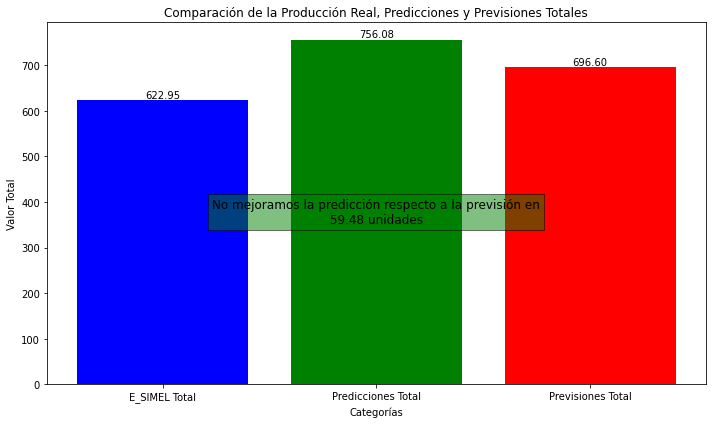

In [47]:
# Valores que cogemos para el gráfico

categorias = ['E_SIMEL Total', 'Predicciones Total', 'Previsiones Total']
valores = [suma_e_simel, sumas_totales_predicciones, sumas_previsiones_real]

# Creamos un gráfico de barras

plt.figure(figsize=(10, 6))
barra = plt.bar(categorias, valores, color=['blue', 'green', 'red'])

# Añadimos las etiquetas

for rect in barra:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# Título del gráfico y ponemos las etiquteas a cada barra
    
plt.title('Comparación de la Producción Real, Predicciones y Previsiones Totales')
plt.xlabel('Categorías')
plt.ylabel('Valor Total')


# Ubicamos el texto de la diferencia

pos_y = valores[1] / 2
pos_x = categorias[1]
plt.text(pos_x, pos_y, f'No mejoramos la predicción respecto a la previsión en\n{diferencia:.2f} unidades', ha='center', va='center', fontsize=12, color='black', bbox=dict(facecolor='green', alpha=0.5))
plt.tight_layout()
plt.show()

In [ ]:
"""
Como podemos comprobar, los resultados no son buenos, por lo tanto, nuestra idea inicial no ha hecho que 
el modelo logra hacer buenas predicciones.

"""